In [ ]:
# import 
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
# geopandas 
from shapely.geometry import Point
import geopandas as gpd

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.colorbar import ColorbarBase
from netCDF4 import Dataset
import cartopy.crs as ccrs

In [151]:
# Inputs
Streamwatershed_path = "/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Streamwatershed/PointWaterdhed_LH_NAD1983.shp"
# Define Core Directories
# -----------------------------
GIS_LAYERS = '/home/abolmaal/Data/GIS_layer'  # For general GIS layers
Lakes = '/mnt/hydroglg/Data/GIS_Data/Derived/MI_Model/Natural_Earth_Great_Lakes_Buffer_Edit.shp'
counties = '/mnt/hydroglg/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_cultural/ne_10m_admin_0_countries_lakes.shp'
#CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/CoastalWatersheds/Erase_Riperian'  # Coastal wetlands (50m buffer)
# CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Coastalwetland/hitshoreline/'  # Alternative path (optional)
out_dir = '/home/abolmaal/modelling/FVCOM/Huron/TotalNP'
# FVCOM grid metrics file
grid_metrics_file_name = '/home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'
# -----------------------------
# Coastal Wetland Shapefiles (Buffered 50m)
# -----------------------------
# CW_avg_path   = os.path.join(CW_path, 'Wetland_connected_avg_erasebuff_50.shp')
# CW_low_path   = os.path.join(CW_path, 'Wetland_connected_low_erasebuff_50.shp')
# CW_high_path  = os.path.join(CW_path, 'Wetland_connected_high_erasebuff_50.shp')
# CW_surge_path = os.path.join(CW_path, 'Wetland_connected_surge_erasebuff_50.shp')
CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/CoastalWatersheds/Buff_CW'
# -----------------------------
# Coastal Wetland Shapefiles (Buffered 50m)
# -----------------------------)
CW_avg_path   = os.path.join(CW_path, 'Wetland_connected_avg_erasebuff_50_buff50_removeoverlap.shp')
CW_low_path   = os.path.join(CW_path, 'Wetland_connected_low_erasebuff_50_buff50_removeoverlap.shp')
CW_high_path  = os.path.join(CW_path, 'Wetland_connected_high_erasebuff_50_buff50_removeoverlap.shp')
CW_surge_path = os.path.join(CW_path, 'Wetland_connected_surge_erasebuff_50_buff50_removeoverlap.shp')
# Load shapefiles as GeoDataFrames
CW_avg   = gpd.read_file(CW_avg_path)
CW_low   = gpd.read_file(CW_low_path)
CW_high  = gpd.read_file(CW_high_path)
CW_surge = gpd.read_file(CW_surge_path)
# FVCOM grid metrics file
grid_metrics_file_name = '/home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'

# -----------------------------
# Direct Nutrient Load (Stream Watersheds)
# -----------------------------
Direct_Nutrient_load = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats/DirectTNTP_StreamWatresheds.csv'
DirectStreamWatershed_NutrientLoad = pd.read_csv(Direct_Nutrient_load)

# InDirect Nutrient Load (Coastal Wetlands)
# -
categories = ['avg', 'high', 'low', 'surge']
year = 23
# read the total loads
for cat in categories:
    total_load_file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{cat}_{year}.csv')
    globals()[f'TotalLoad_CW_{cat}'] = pd.read_csv(total_load_file)


In [159]:
# read the shapefile for Lakes
Lakes = gpd.read_file(Lakes)

In [153]:
counties = gpd.read_file(counties)

# Parameters

In [10]:
release_times = ["2301", "2302", "2303", "2304", "2305", "2306", "2307", "2308", "2309", "2310", "2311", "2312"]

# Figure parameters
# Custom colormap setup (pink and blue shades)
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

# Define a list of green shades for the colormap
green_shades =  ['#e0ffe0', '#b3ffb3', '#80ff80', '#4dff4d', '#00e600', '#00cc00', '#009900', '#006600', '#003300']
# Create a custom green colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Replace pink_cmap with viridis and plasma
viridis_cmap = plt.colormaps['viridis']  # Updated to use new interface
plasma_cmap = plt.colormaps['plasma']  # Updated to use new interface
reversed_plasma_cmap = plasma_cmap.reversed()  # Reversed colormap  
# Set up plotting parameters
font_size = 15
cmap = plt.colormaps['hsv_r']  # Fixed: using an existing colormap (hsv_r)

# Extent of the plot
extents = np.array([275, 277.69, 43, 46.3], dtype=float)

extents_ausable = np.array([276.5, 276.8, 45, 45.5], dtype=float)

# Some parameters for the Zonal Stats Fields
# Fields to calculate / Direct delivery to Watersheds
# Fields to calculate / Direct delivery to Watersheds
StreamDirectTN = 'StreamDirectTN_kgday'
StreamDirectTP = 'StreamDirectTP_kgday'

In [7]:
output_figures = '/home/abolmaal/modelling/FVCOM/Huron/Figures'

In [6]:
# read TotalIndirectLoad_CW_avg
TotalLoad_CW_avg.columns

Index(['CW_Id', 'start_lat', 'start_lon',
       'CoastalWatershedDirectTN_avg_grm2yr',
       'CoastalWatershedDirectTP_avg_grm2yr', 'TotalIndirectCW_TN_grm2yr',
       'TotalIndirectCW_TP_grm2yr', 'TotalN_avg_grm2yr', 'TotalP_avg_grm2yr',
       'Wetland', 'group_ids', 'particle_ids'],
      dtype='object')

# Plot Functions

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [ ]:
watershed_gdf = gpd.read_file(Streamwatershed_path)

# Reproject if needed
if watershed_gdf.crs != "EPSG:4326":
    watershed_gdf = watershed_gdf.to_crs("EPSG:4326")

In [ ]:
import os
import geopandas as gpd
import numpy as np
import h3
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Polygon

def plot_wetload_choropleth_interactive(
    df, 
    category,
    resolution=6,
    map_extent=None,
    watershed_shapefile_path=None,
    lakes_shapefile_path=None,
    counties_shapefile_path=None,
    output_figures="outputs"
):
    """
    Create an interactive hexbin choropleth map of nutrient loads.
    - df: DataFrame containing TotalN_{category}_grm2yr, start_lat, start_lon.
    - category: 'avg', 'low', 'high', or 'surge'.
    - resolution: H3 hex resolution.
    - map_extent: (lon_min, lon_max, lat_min, lat_max) or None.
    - watershed_shapefile_path: path or GeoDataFrame for watershed overlay.
    - lakes_shapefile_path: path to Great Lakes shapefile.
    - counties_shapefile_path: path to counties shapefile.
    """
    # Create GeoDataFrame from coordinates
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['start_lon'], df['start_lat']),
        crs='EPSG:4326'
    )

    # Assign H3 index and aggregate
    gdf['h3_index'] = gdf.geometry.apply(lambda p: h3.latlng_to_cell(p.y, p.x, resolution))
    agg_df = gdf.groupby('h3_index')[f'TotalN_{category}_grm2yr'].sum().reset_index()

    # Convert hex indexes to polygons
    agg_df['geometry'] = agg_df['h3_index'].apply(
        lambda cell: Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(cell)])
    )
    agg_df['log_load'] = np.log10(agg_df[f'TotalN_{category}_grm2yr'] + 1e-6)
    hex_gdf = gpd.GeoDataFrame(agg_df, geometry='geometry', crs='EPSG:4326')
    hex_gdf['id'] = hex_gdf.index.astype(str)
    geojson_data = hex_gdf.__geo_interface__

    # Map extent
    if map_extent:
        lon_min, lon_max, lat_min, lat_max = map_extent
        center_lon = (lon_min + lon_max) / 2
        center_lat = (lat_min + lat_max) / 2
        zoom = 6
    else:
        center_lon, center_lat, zoom = -82.5, 44.5, 6

    # Create base choropleth
    fig = px.choropleth_map(
        hex_gdf,
        geojson=geojson_data,
        locations='id',
        color='log_load',
        zoom=zoom,
        center={"lat": center_lat, "lon": center_lon},
        opacity=0.7,
        map_style="carto-positron",
        color_continuous_scale="rainbow",
        labels={"log_load": f"Log₁₀(Total N {category} g/m²/yr)"}
    )

    # Optional watershed overlay
    if watershed_shapefile_path is not None:
        if isinstance(watershed_shapefile_path, gpd.GeoDataFrame):
            watershed_gdf = watershed_shapefile_path
        else:
            watershed_gdf = gpd.read_file(watershed_shapefile_path)
        if watershed_gdf.crs != "EPSG:4326":
            watershed_gdf = watershed_gdf.to_crs("EPSG:4326")
        for _, row in watershed_gdf.iterrows():
            if row.geometry is None:
                continue
            for geom in ([row.geometry] if row.geometry.geom_type != 'MultiPolygon' else row.geometry.geoms):
                if geom.geom_type == 'Polygon':
                    lons, lats = zip(*list(geom.exterior.coords))
                    fig.add_trace(go.Scattermap(lon=lons, lat=lats, mode='lines',
                                                line=dict(width=1, color='green'),
                                                name='Watershed'))

    # Optional lakes overlay
    if lakes_shapefile_path and os.path.exists(lakes_shapefile_path):
        lakes_gdf = gpd.read_file(lakes_shapefile_path)
        if lakes_gdf.crs != "EPSG:4326":
            lakes_gdf = lakes_gdf.to_crs("EPSG:4326")
        for _, row in lakes_gdf.iterrows():
            if row.geometry is None:
                continue
            for geom in ([row.geometry] if row.geometry.geom_type != 'MultiPolygon' else row.geometry.geoms):
                if geom.geom_type == 'Polygon':
                    lons, lats = zip(*list(geom.exterior.coords))
                    fig.add_trace(go.Scattermap(lon=lons, lat=lats, mode='lines',
                                                line=dict(width=1.5, color='blue'),
                                                name='Great Lakes'))

    # Optional counties overlay
    if counties_shapefile_path and os.path.exists(counties_shapefile_path):
        counties_gdf = gpd.read_file(counties_shapefile_path)
        if counties_gdf.crs != "EPSG:4326":
            counties_gdf = counties_gdf.to_crs("EPSG:4326")
        for _, row in counties_gdf.iterrows():
            if row.geometry is None:
                continue
            for geom in ([row.geometry] if row.geometry.geom_type != 'MultiPolygon' else row.geometry.geoms):
                if geom.geom_type == 'Polygon':
                    lons, lats = zip(*list(geom.exterior.coords))
                    fig.add_trace(go.Scattermap(lon=lons, lat=lats, mode='lines',
                                                line=dict(width=0.8, color='black'),
                                                name='Country/County'))

    # Layout
    fig.update_layout(
        title=f"Log-Scaled Indirect Nitrogen Load ({category}) with Overlays",
        mapbox_style="carto-positron",
        mapbox_zoom=zoom,
        mapbox_center={"lat": center_lat, "lon": center_lon},
        margin={"r": 0, "t": 40, "l": 0, "b": 0}
    )

    os.makedirs(output_figures, exist_ok=True)
    fig.write_html(os.path.join(output_figures, f"WetLoad_Choropleth_{category}.html"))
    fig.write_image(os.path.join(output_figures, f"WetLoad_Choropleth_{category}.jpeg"), format="jpeg", scale=2)
    fig.show()


In [ ]:
categories = ['avg', 'high', 'low', 'surge']

for cat in categories:
    df = globals()[f"TotalIndirectLoad_CW_{cat}"]
    plot_wetload_choropleth_interactive(
        df,
        category=cat,
        resolution=6,
        watershed_shapefile_path=Streamwatershed_path,
        lakes_shapefile_path=Lakes,
        counties_shapefile_path=counties,
        output_figures=out_dir
    )


## plot with zoom in extents

In [ ]:

main_extents=[275,279,43,46.3],  # Main extent

zoom_extents_1=[276.5,276.8,44.8,45.5],#zoomed-in extent
zoom_extents_2=[276.5, 276, 43.58, 44],   # Zoomed-in extent
zoom_extents_3=[277.5, 277, 43.5, 44],   # Zoomed-in exten

### TN

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import numpy as np
from netCDF4 import Dataset
import cartopy.crs as ccrs

def get_log_custom_colormap():
    colors = [
        "#00004C", "#0000A0", "#4B0082", "#800080", "#8B008B",
        "#A020F0", "#DA70D6", "#FFD700", "#FFA500", "#FF7F50",
        "#FF6347", "#FF4500", "#FF0000", "#CC0000", "#800000"
    ]
    boundaries = np.logspace(-9, -6, len(colors) + 1)
    cmap = mcolors.ListedColormap(colors, name="log_colormap")
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)
    return cmap, norm, boundaries

def plot_wetload_distribution_TN_with_three_insets(
    merged_data,
    cat,
    grid_metrics_file_name,
    main_extents,
    zoom_extents_1,
    zoom_extents_2,
    zoom_extents_3,
    font_size=15,
    title=None,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],
    inset_position_2=[0.1, 0.40, 0.18, 0.18],
    inset_position_3=[0.50, 0.25, 0.18, 0.18],
    colorbar_outside=True,
    vmin=None,
    vmax=None,
    output_figures='.'
):
    # Get the colormap
    cmap, norm, boundaries = get_log_custom_colormap()

    # Use category-specific column
    tn_col = f'TotalN_{cat}_grm2yr'
    wetload_tn = merged_data[tn_col].values
    all_coords = np.array(list(zip(merged_data['start_lon'], merged_data['start_lat'])))

    # Set up the plot
    fig, ax_main = plt.subplots(figsize=(26, 26), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title if title else f'Indirect Annual Nitrogen Load to Coastal Wetlands ({cat})', fontsize=font_size + 5)

    # Load bathymetry
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Assuming you already have FVCOMPlotter defined elsewhere
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

    # Plot bathymetry
    ax_main, plot_main = plotter.plot_field(
        ax_main, bathy, extents=main_extents, add_colour_bar=True, cb_label='Depth(m)', vmin=-60., vmax=0., cmap='Blues', zorder=0
    )
    plotter.draw_grid(ax_main, linewidth=0.5)

    # Hexbin main map
    hb_main = ax_main.hexbin(
        all_coords[:, 0], all_coords[:, 1],
        C=wetload_tn, gridsize=50,
        norm=LogNorm(), cmap=cmap,
        reduce_C_function=np.sum,
        zorder=40, vmin=vmin, vmax=vmax
    )

    # Colorbar
    cbar_main = fig.colorbar(hb_main, ax=ax_main, pad=0.1 if colorbar_outside else 0.15)
    cbar_main.set_label('Nitrogen Load (g/m²/yr)', fontsize=font_size + 5)
    cbar_main.ax.tick_params(labelsize=font_size + 2)
    cbar_main.set_ticks(boundaries)

    ax_main.set_xlabel('Longitude', fontsize=font_size)
    ax_main.set_ylabel('Latitude', fontsize=font_size)

    if vmin is not None or vmax is not None:
        cbar_main.set_clim(vmin, vmax)

    # Plot 3 insets
    inset_positions = [inset_position_1, inset_position_2, inset_position_3]
    zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
    colors = ['red', 'blue', 'green']

    for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
        ax_inset = plt.axes(inset_pos, projection=ccrs.PlateCarree())
        ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())

        ax_inset, plot_zoom = plotter.plot_field(
            ax_inset, bathy, extents=zoom_extent, add_colour_bar=False,
            cb_label=None, vmin=-60., vmax=0., cmap='Blues', zorder=0
        )
        plotter.draw_grid(ax_inset, linewidth=0.5)

        hb_zoom = ax_inset.hexbin(
            all_coords[:, 0], all_coords[:, 1],
            C=wetload_tn, gridsize=50,
            norm=LogNorm(), cmap=cmap,
            reduce_C_function=np.sum,
            zorder=40, vmin=vmin, vmax=vmax
        )

        ax_inset.set_title(f"Enlarge view {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

        # Rectangle on main plot
        rect = plt.Rectangle(
            (zoom_extent[0], zoom_extent[2]),
            zoom_extent[1] - zoom_extent[0],
            zoom_extent[3] - zoom_extent[2],
            linewidth=2, edgecolor=color, facecolor='none',
            transform=ccrs.PlateCarree(), zorder=50
        )
        ax_main.add_patch(rect)

    plt.savefig(f"{output_figures}/WetLoadDistribution_{cat}_TN_gperm2peryear.png", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


### TP

In [ ]:
def plot_wetload_distribution_TP_with_three_insets(
    merged_data, 
    grid_metrics_file_name, 
    main_extents, 
    zoom_extents_1, 
    zoom_extents_2, 
    zoom_extents_3, 
    color_map, 
    font_size=15, 
    title=None,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height] 
    colorbar_outside=True,
    vmin=None,   # Optional minimum value for colorbar range
    vmax=None    # Optional maximum value for colorbar range
):
    """
    Creates a hexbin plot showing the WetLoad_TN_kg2 concentration in coastal wetlands with bathymetry background,
    with three zoomed-in maps inside or near the main map. 
    Each zoom-in region is enclosed with a colored box that matches the zoomed-in map's title color.
    """
    # Collect coordinates and WetLoad_TN_kg2 data for plotting
    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tp = merged_data['massUnitAreayrTP(gr/m2/yr)'].values

    # Create the figure and main axis
    fig, ax_main = plt.subplots(figsize=(26., 26.), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title if title else 'Indirect Annual Phosphorous Load to Coastal Wetlands', fontsize=font_size + 5)

    # Load bathymetry data from NetCDF
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter for bathymetry
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

    # Plot the main extent
    ax_main, plot_main = plotter.plot_field(
        ax_main, bathy, extents=main_extents, add_colour_bar=True, cb_label='Depth(m)', vmin=-60., vmax=0., cmap='Blues', zorder=0
    )
    plotter.draw_grid(ax_main, linewidth=0.5)

    # Hexbin plot with optional vmin and vmax for the colorbar range
    hb_main = ax_main.hexbin(
        all_coords[:, 0], 
        all_coords[:, 1], 
        C=wetload_tp, 
        gridsize=50, 
        cmap=color_map, 
        norm=LogNorm(),
        reduce_C_function=np.sum, 
        zorder=40, 
        vmin=vmin,  # Set the minimum value of the color range
        vmax=vmax   # Set the maximum value of the color range
    )

    # Add color bar for main extent with increased font size
    if colorbar_outside:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, pad=0.1)
    else:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, shrink=0.8, location="right", pad=0.15)
    cbar_main.set_label('Phosphorous Load (g/m2/yr)', fontsize=font_size + 5)  # Increased font size for label
    cbar_main.ax.tick_params(labelsize=font_size + 2)  # Increase font size for tick labels

    ax_main.set_xlabel('Longitude', fontsize=font_size)
    ax_main.set_ylabel('Latitude', fontsize=font_size)

    # Adjust the colorbar limits if needed
    if vmin is not None or vmax is not None:
        cbar_main.set_clim(vmin, vmax)

    # Define inset positions, extents, and titles
    inset_positions = [inset_position_1, inset_position_2, inset_position_3]
    zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
    colors = ['red', 'blue', 'green']
    
    # Iterate over three insets
    for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
        # Create inset axis
        ax_inset = plt.axes(inset_pos, projection=ccrs.PlateCarree())
        ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())
        
        # Plot inset bathymetry
        ax_inset, plot_zoom = plotter.plot_field(
            ax_inset, bathy, extents=zoom_extent, add_colour_bar=False, cb_label=None, vmin=-60., vmax=0., cmap='Blues', zorder=0
        )
        plotter.draw_grid(ax_inset, linewidth=0.5)

        # Add hexbin plot for the inset zoom area using the same color map and optional color range
        hb_zoom = ax_inset.hexbin(
            all_coords[:, 0], 
            all_coords[:, 1], 
            C=wetload_tp, 
            gridsize=50, 
            cmap=color_map, 
            norm=LogNorm(),
            reduce_C_function=np.sum, 
            zorder=40, 
            vmin=vmin,  # Set the minimum value of the color range for zoom
            vmax=vmax   # Set the maximum value of the color range for zoom
        )

        # Set inset title with matching color
        ax_inset.set_title(f"Enlarge view {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

        # Add rectangle to highlight the zoomed-in region with matching color
        rect = plt.Rectangle(
            (zoom_extent[0], zoom_extent[2]), 
            zoom_extent[1] - zoom_extent[0], 
            zoom_extent[3] - zoom_extent[2],
            linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=50
        )
        ax_main.add_patch(rect)

        # **NEW CODE**: Draw a colored border around each zoom-in box
        inset_box = plt.Rectangle(
            (inset_pos[0], inset_pos[1]),  # Position of the inset box on the figure
            inset_pos[2],                  # Width of the inset box
            inset_pos[3],                  # Height of the inset box
            linewidth=3, edgecolor=color, facecolor='none', linestyle='-', zorder=60
        )
        ax_main.add_patch(inset_box)
        
    # Save the plot
    plt.savefig(output_figures + '/WetLoadDistribution_AvgInun_Phosphorus_gperm2peryear.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()

In [113]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from netCDF4 import Dataset

def plot_wetload_distribution(
    cat,
    grid_metrics_file_name,
    value_type="N",  # or "P"
    font_size=16,
    title=None,
    colorbar_outside=True,
    vmin=1e-6,
    vmax=1e-1,
    output_figures='.',
    extent=[-86, -81, 42.5, 46.5]
):
    # Get dataframe from globals
    df = globals().get(f'TotalLoad_CW_{cat}')
    if df is None:
        raise ValueError(f"No dataframe found for category '{cat}'")
    df = df[
    (df['start_lon'] != 0.0) & 
    (df['start_lat'] != 0.0) &
    (~df['start_lon'].isna()) & 
    (~df['start_lat'].isna())
]
    # Clip to grid extent
    lon_min, lon_max = -88.1, -79.7
    lat_min, lat_max = 41.5, 46.5

    df = df[
        (df['start_lon'] >= lon_min) & (df['start_lon'] <= lon_max) &
        (df['start_lat'] >= lat_min) & (df['start_lat'] <= lat_max)
    ]
    coords = np.array(list(zip(df['start_lon'], df['start_lat'])))
    

    col_key = f"Total{value_type}_{cat}_grm2yr"
    if col_key not in df.columns:
        raise ValueError(f"Column '{col_key}' not found in dataframe")

    lon = df['start_lon'].values
    lat = df['start_lat'].values
    values = df[col_key].values

    # Load bathymetry data
    with Dataset(grid_metrics_file_name, 'r') as ds:
        lon_bathy = ds.variables['longitude'][:]
        lat_bathy = ds.variables['latitude'][:]
        depth = -ds.variables['h'][:]  # Make depth negative for plotting

    # Filter valid depth data
    valid = (~np.isnan(lon_bathy)) & (~np.isnan(lat_bathy)) & (~np.isnan(depth))
    lon_valid = lon_bathy[valid]
    lat_valid = lat_bathy[valid]
    depth_valid = depth[valid]

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(18, 10))

    # Bathymetry scatter
    ax.scatter(
        lon_valid, lat_valid, c=depth_valid,
        cmap='Blues', alpha=0.4, s=2, zorder=0
    )

    # Wetload hexbin
    hb = ax.hexbin(
        lon, lat, C=values,
        gridsize=35,
        cmap= "rainbow",
        #norm=LogNorm(vmin=vmin, vmax=vmax),
        reduce_C_function=np.mean,
        edgecolors='none',
        zorder=1
    )

    # Colorbar
    cbar = fig.colorbar(hb, ax=ax, pad=0.02 if colorbar_outside else 0.1)
    cbar.set_label(f'{value_type} Load (g/m²/yr)', fontsize=font_size)
    cbar.ax.tick_params(labelsize=font_size - 2)

    # Labels, extent, title
    ax.set_title(title or f"{value_type} Load - {cat}", fontsize=font_size + 2)
    ax.set_xlabel("Longitude", fontsize=font_size)
    ax.set_ylabel("Latitude", fontsize=font_size)
    ax.tick_params(labelsize=font_size - 2)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect('equal')

    # Save and show
    outpath = f"{output_figures}/WetLoad_{value_type}_{cat}.png"
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {outpath}")
    plt.show()


### run zoom in functions

In [168]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import geopandas as gpd
from shapely.geometry import box
bbox = box(-86, -81, 42.5, 46.5)
counties_clipped = counties[counties.intersects(bbox)]

def plot_wetload_distribution(
    cat,
    Lakes,
    Counties,
    value_type="N",  # or "P"
    font_size=16,
    title=None,
    colorbar_outside=True,
    output_figures='.',
    extent=[-86, -81, 42.5, 46.5]
):
    # Get dataframe from globals
    df = globals().get(f'TotalLoad_CW_{cat}')
    if df is None:
        raise ValueError(f"No dataframe found for category '{cat}'")

    # Clean invalid coordinates
    df = df[
        (df['start_lon'] != 0.0) & 
        (df['start_lat'] != 0.0) &
        (~df['start_lon'].isna()) & 
        (~df['start_lat'].isna())
    ]

    # Clip to extent
    lon_min, lon_max = extent[0], extent[1]
    lat_min, lat_max = extent[2], extent[3]
    df = df[
        (df['start_lon'] >= lon_min) & (df['start_lon'] <= lon_max) &
        (df['start_lat'] >= lat_min) & (df['start_lat'] <= lat_max)
    ]

    # Column with load values
    col_key = f"Total{value_type}_{cat}_grm2yr"
    if col_key not in df.columns:
        raise ValueError(f"Column '{col_key}' not found in dataframe")

    lon = df['start_lon'].values
    lat = df['start_lat'].values
    values = df[col_key].values

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(18, 10))

    # Plot lakes and counties
    counties_clipped.plot(ax=ax, facecolor='black', edgecolor='gray', linewidth=0.8, zorder=0)
    Lakes.plot(ax=ax, facecolor='lightblue', edgecolor='black', alpha=0.5, zorder=1)

    # Quantile-based color normalization
    q_min = np.nanquantile(values, 0.05)
    q_max = np.nanquantile(values, 0.95)

    # Wetload hexbin
    hb = ax.hexbin(
        lon, lat, C=values,
        gridsize=35,
        cmap="rainbow",
        norm=LogNorm(vmin=q_min, vmax=q_max),
        reduce_C_function=np.mean,
        edgecolors='none',
        zorder=2
    )

    # Colorbar
    cbar = fig.colorbar(hb, ax=ax, pad=0.02 if colorbar_outside else 0.1)
    cbar.set_label(f'{value_type} Load (g/m²/yr)', fontsize=font_size)
    cbar.ax.tick_params(labelsize=font_size - 2)

    # Labels and layout
    ax.set_title(title or f"{value_type} Load - {cat}", fontsize=font_size + 2)
    ax.set_xlabel("Longitude", fontsize=font_size)
    ax.set_ylabel("Latitude", fontsize=font_size)
    ax.tick_params(labelsize=font_size - 2)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect('equal')

    # Save figure
    outpath = f"{output_figures}/WetLoad_{value_type}_{cat}.png"
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {outpath}")
    plt.show()


✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/WetLoad_N_avg.png


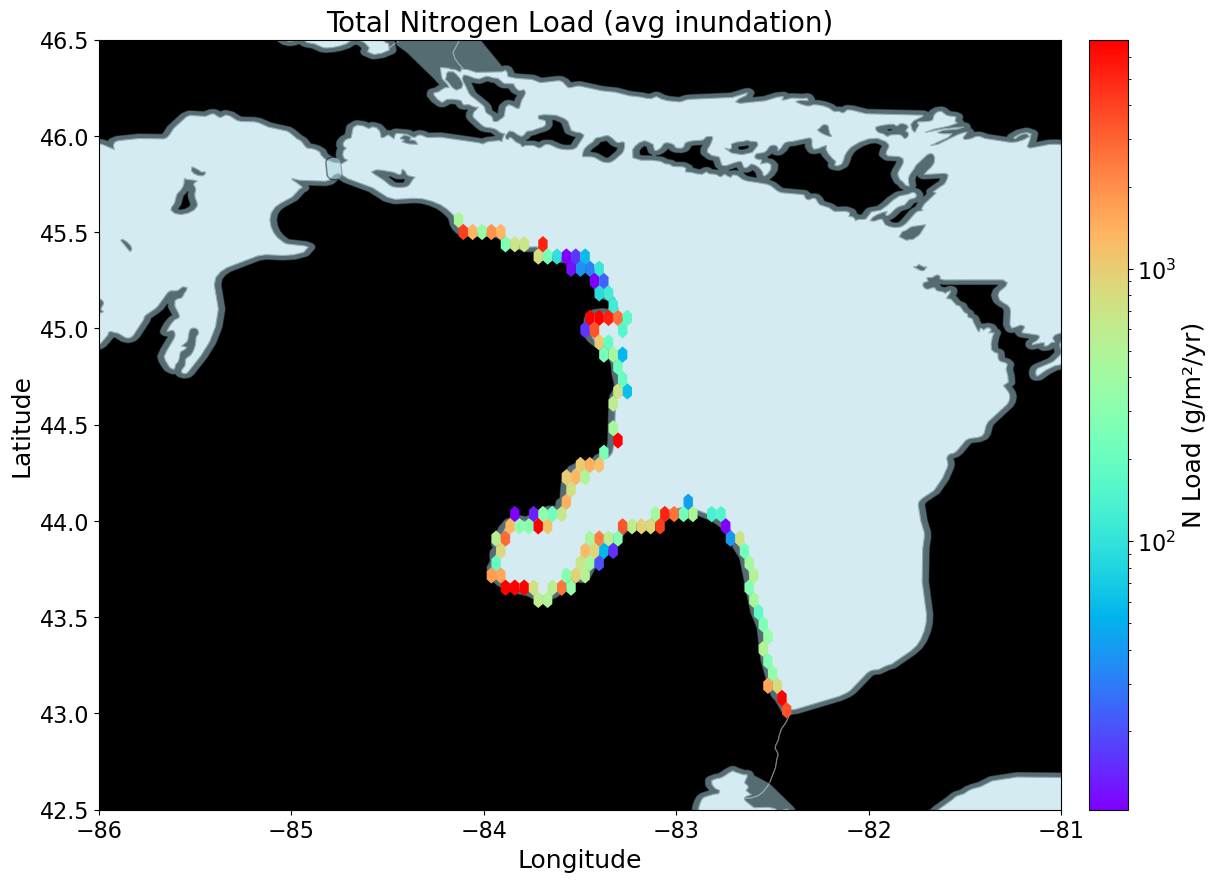

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/WetLoad_N_high.png


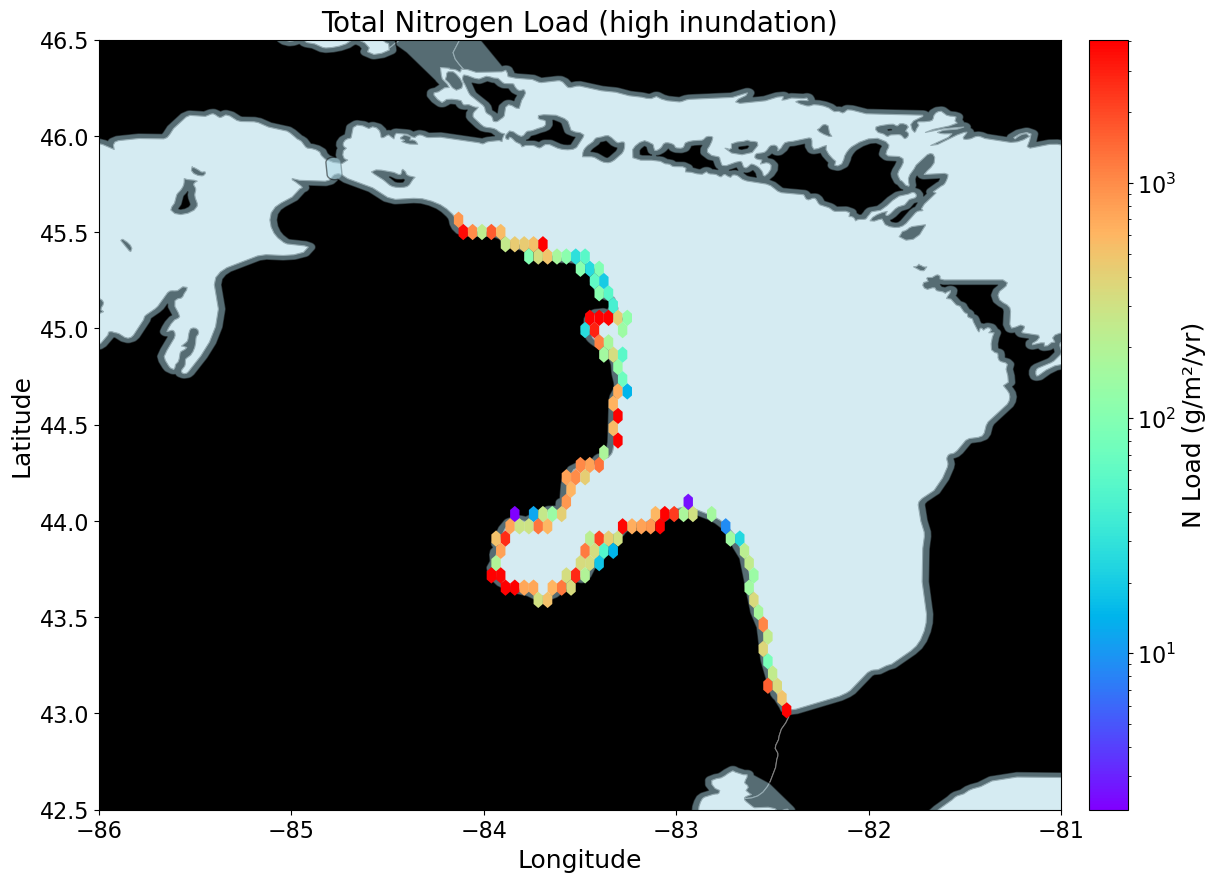

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/WetLoad_N_low.png


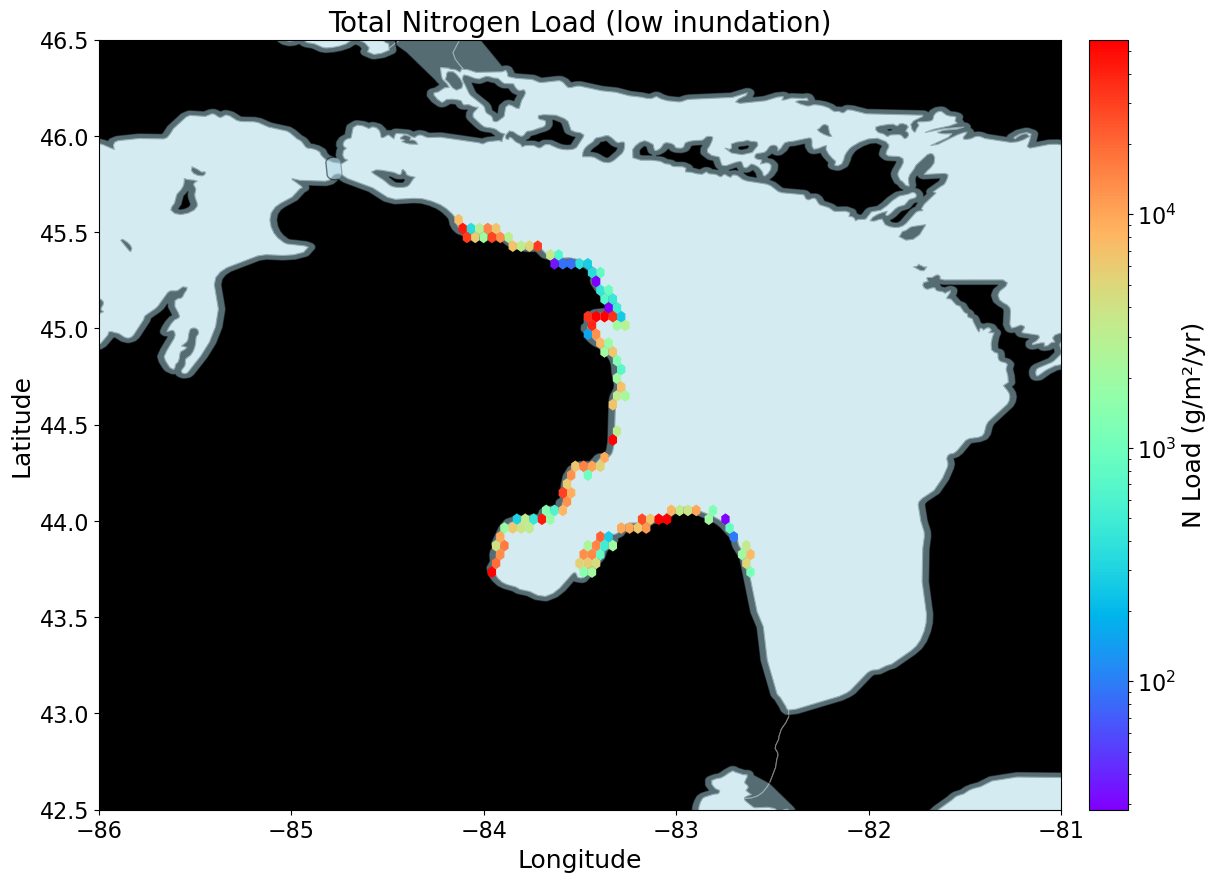

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/WetLoad_N_surge.png


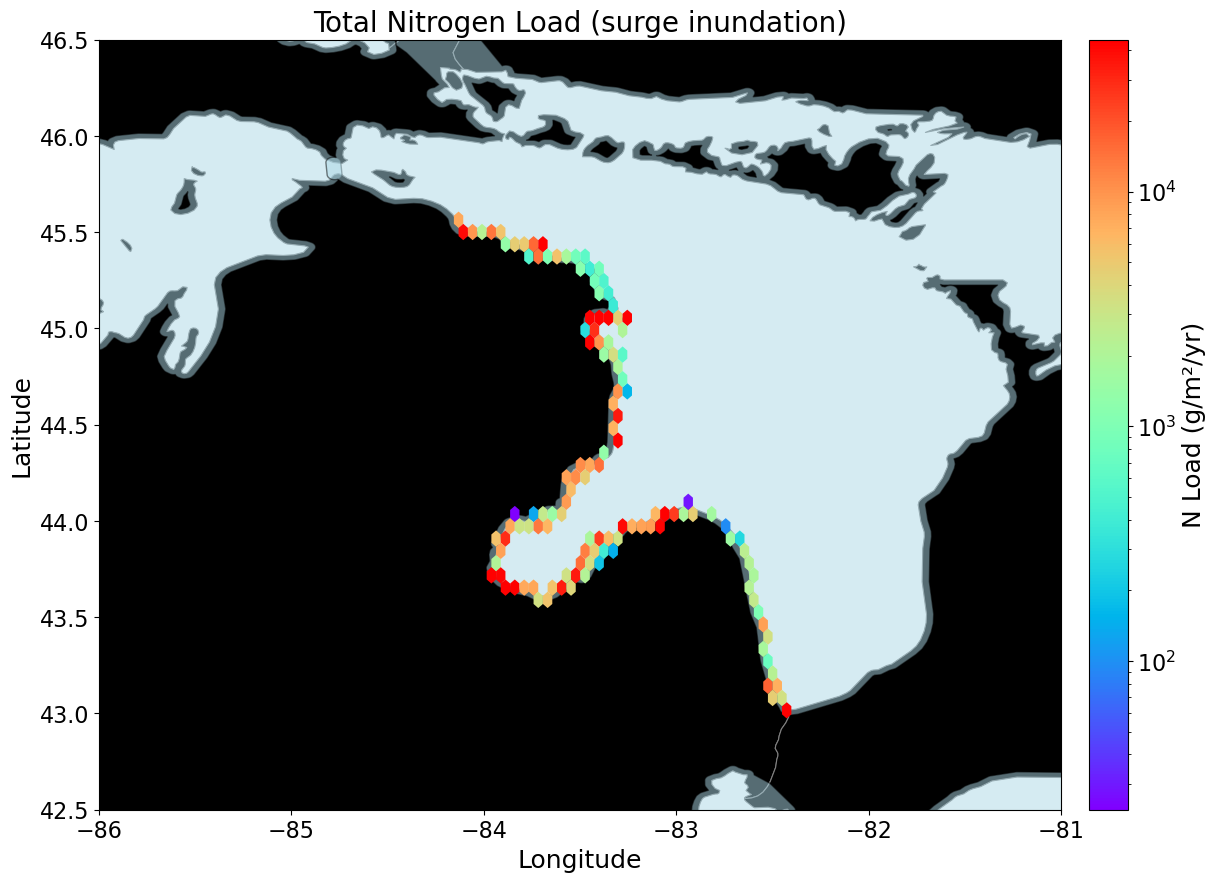

In [169]:
for cat in ['avg', 'high', 'low', 'surge']:
    plot_wetload_distribution(
        cat=cat,
        Lakes=Lakes,
        Counties=counties,
        value_type="N",  # or "P"
        font_size=18,
        title=f"Total Nitrogen Load ({cat} inundation)",
        output_figures=out_dir
    )

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/WetLoad_P_avg.png


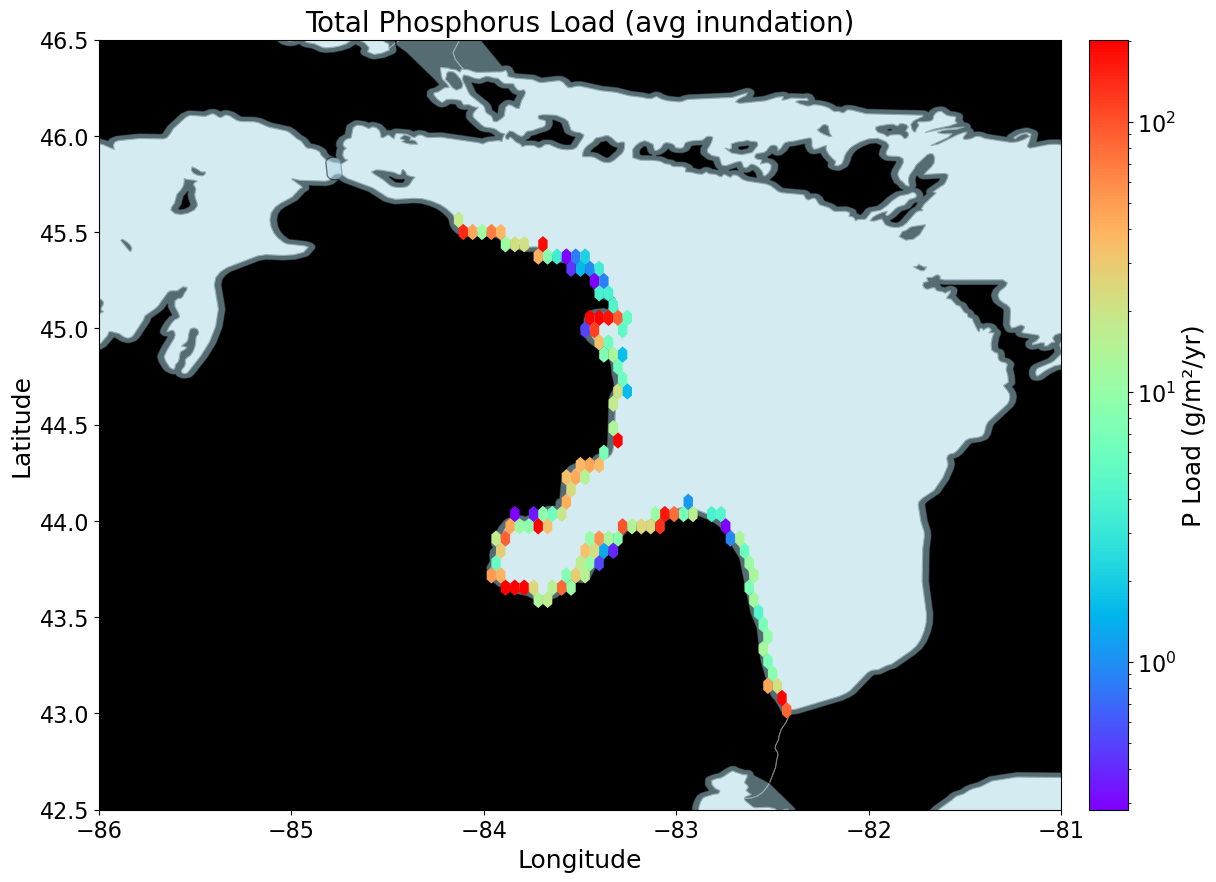

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/WetLoad_P_high.png


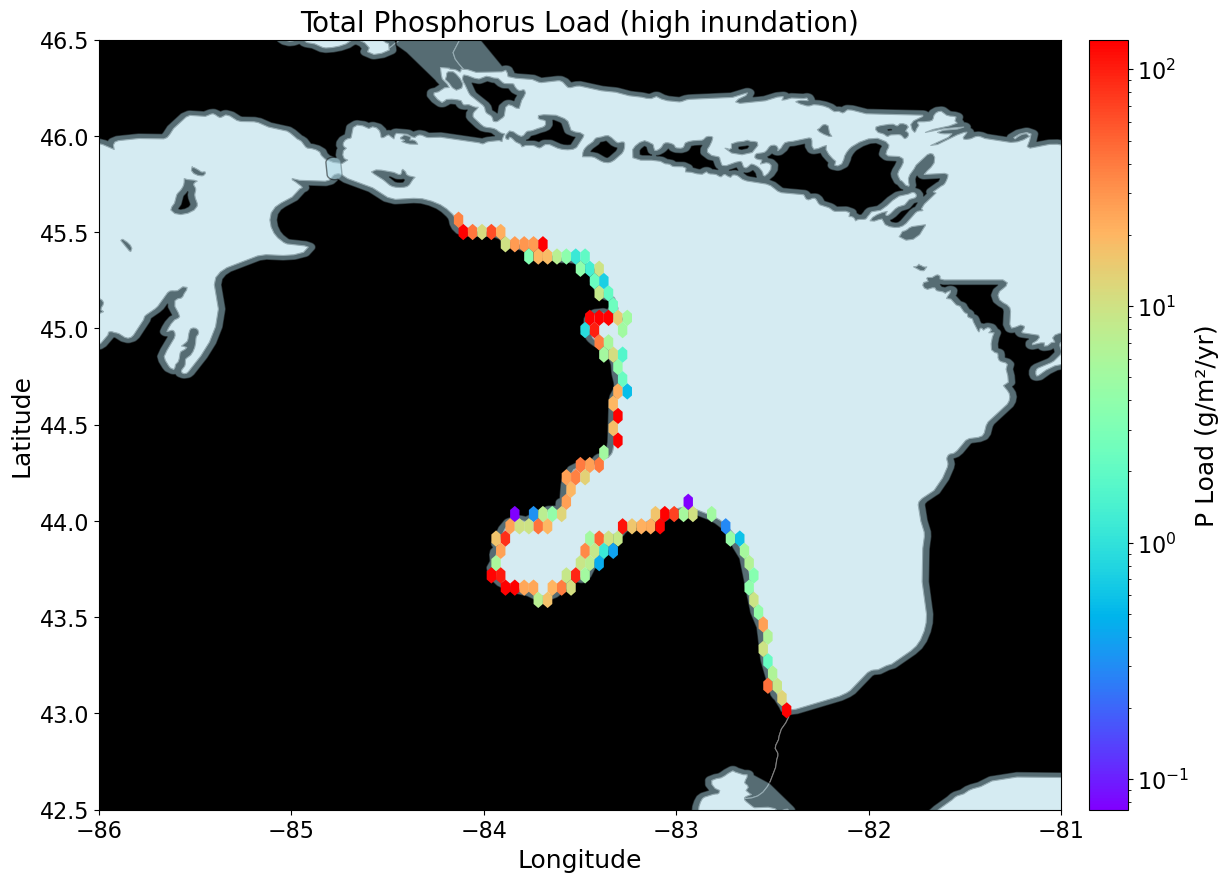

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/WetLoad_P_low.png


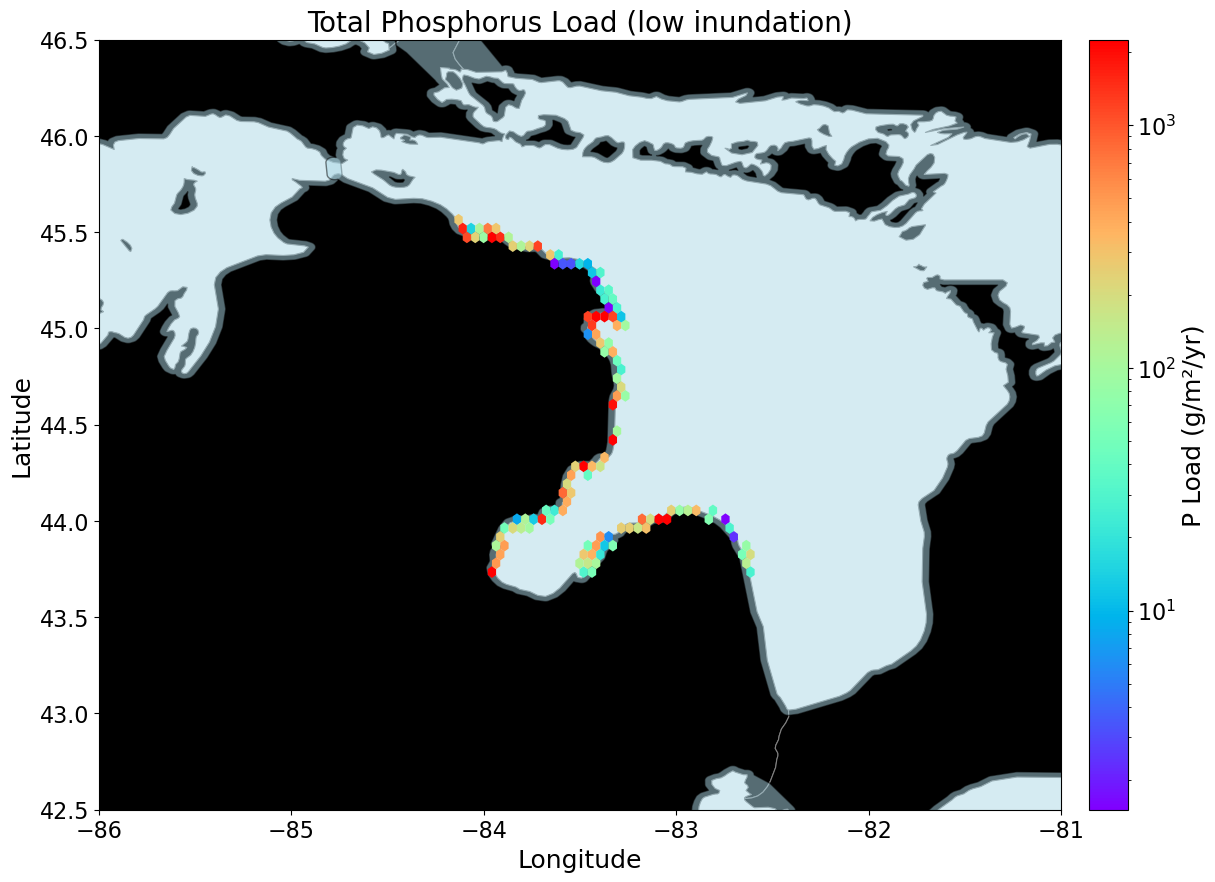

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/WetLoad_P_surge.png


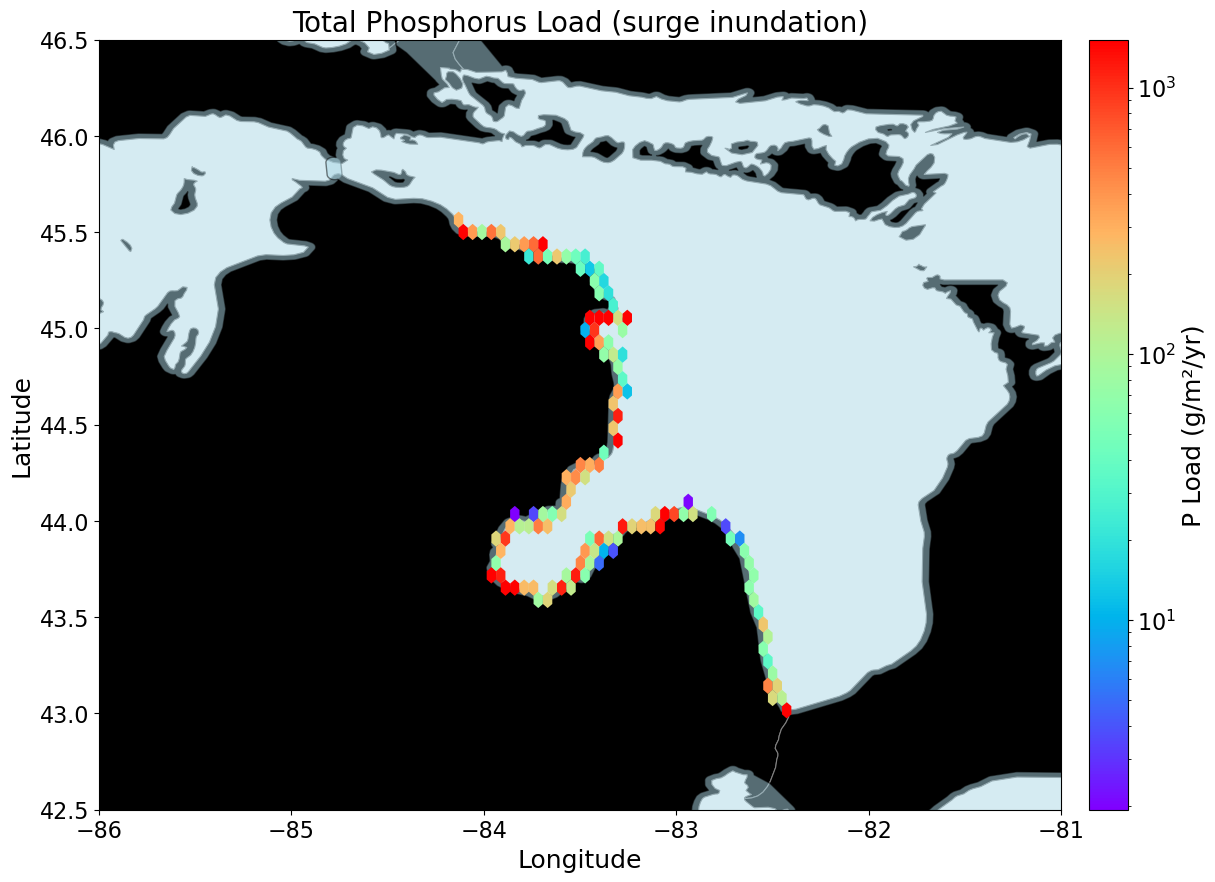

In [170]:
for cat in ['avg', 'high', 'low', 'surge']:
    plot_wetload_distribution(
        cat=cat,
        Lakes=Lakes,
        Counties=counties,
        value_type="P",  # or "P"
        font_size=18,
        title=f"Total Phosphorus Load ({cat} inundation)",
        output_figures=out_dir
    )

### wetlands geographic location 

In [171]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import os

def plot_wetload_distribution(
    cat,
    Lakes: gpd.GeoDataFrame,
    font_size=16,
    title=None,
    output_figures='.',
    extent=[-85, -81, 42.5, 46.5]
):
    # Get dataframe from globals
    df = globals().get(f'TotalLoad_CW_{cat}')
    if df is None:
        raise ValueError(f"No dataframe found for category '{cat}'")

    # Clean invalid coordinates
    df = df[
        (df['start_lon'] != 0.0) &
        (df['start_lat'] != 0.0) &
        (~df['start_lon'].isna()) &
        (~df['start_lat'].isna())
    ].copy()

    # Require Wetland column
    if 'Wetland' not in df.columns:
        raise ValueError("Column 'Wetland' not found in dataframe")

    # Clip to extent
    minx, maxx, miny, maxy = extent
    df = df[
        (df['start_lon'] >= minx) & (df['start_lon'] <= maxx) &
        (df['start_lat'] >= miny) & (df['start_lat'] <= maxy)
    ].copy()

    # Unique wetland categories (sorted for stable legend order)
    cats = sorted([c for c in df['Wetland'].dropna().unique()])

    # Choose a palette with enough distinct colors
    cmap = plt.get_cmap('tab10')
    color_map = {c: cmap(i % cmap.N) for i, c in enumerate(cats)}

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(18, 10))

    # Lakes
    Lakes.plot(ax=ax, facecolor='lightblue', edgecolor='black', alpha=0.5, zorder=0)

    # Scatter points by wetland category
    for c in cats:
        sub = df[df['Wetland'] == c]
        ax.scatter(
            sub['start_lon'], sub['start_lat'],
            s=25, alpha=0.9, label=f"{c} (n={len(sub)})",
            color=color_map[c], zorder=1
        )

    # Labels and layout
    ax.set_title(title or f"Wetland Categories - {cat}", fontsize=font_size + 2)
    ax.set_xlabel("Longitude", fontsize=font_size)
    ax.set_ylabel("Latitude", fontsize=font_size)
    ax.tick_params(labelsize=font_size - 2)
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_aspect('equal')

    # Legend outside the plot
    ax.legend(title="Wetland", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=font_size-3)

    # Save figure
    os.makedirs(output_figures, exist_ok=True)
    outpath = f"{output_figures}/WetlandCats_{cat}.png"
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {outpath}")
    plt.show()


✅ Saved: figures/WetlandCats_avg.png


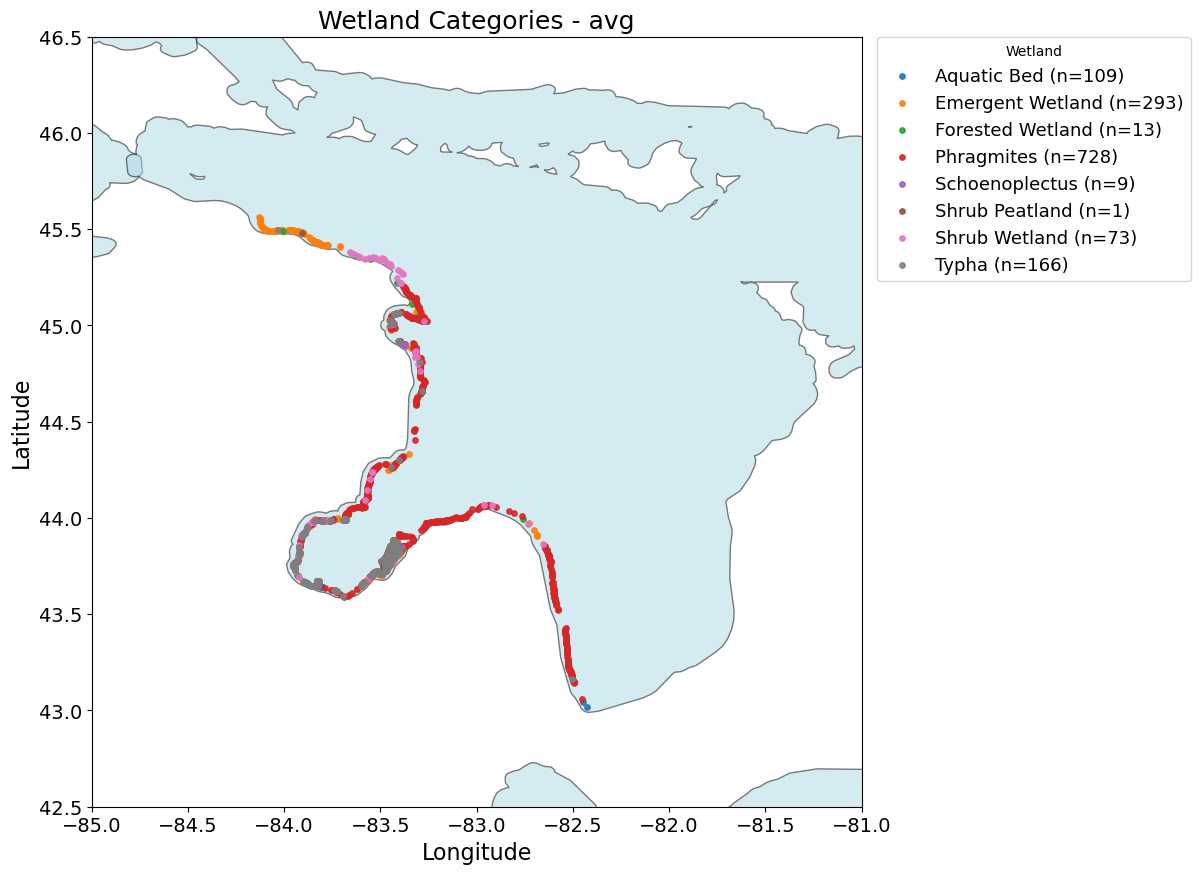

✅ Saved: figures/WetlandCats_high.png


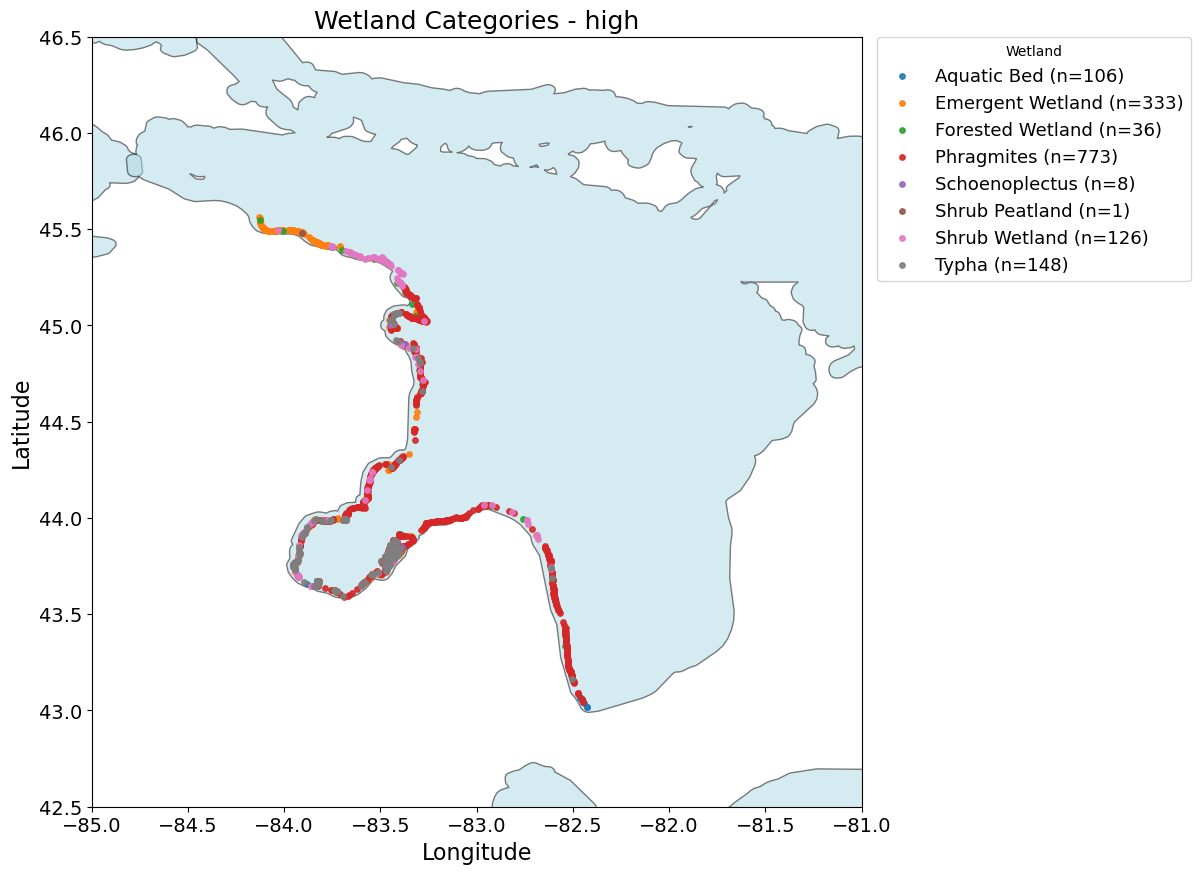

✅ Saved: figures/WetlandCats_low.png


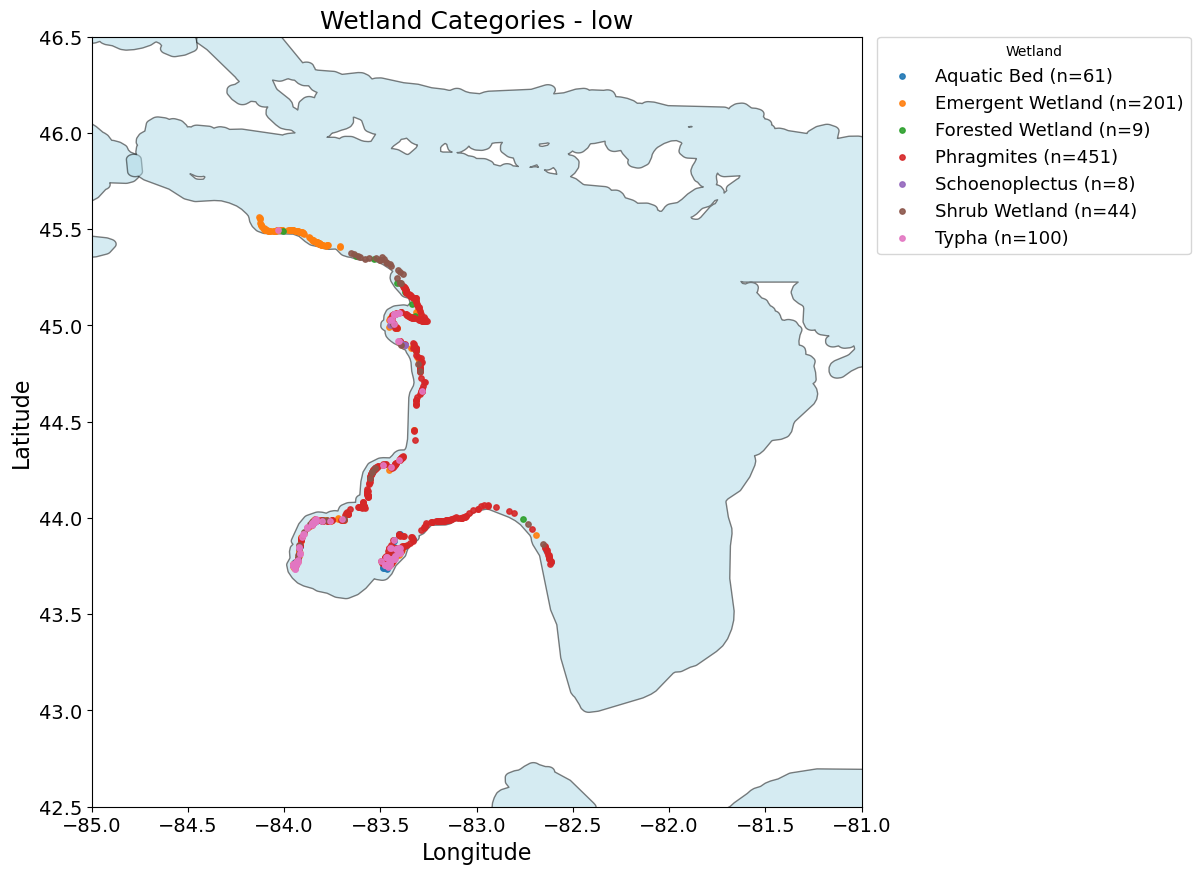

✅ Saved: figures/WetlandCats_surge.png


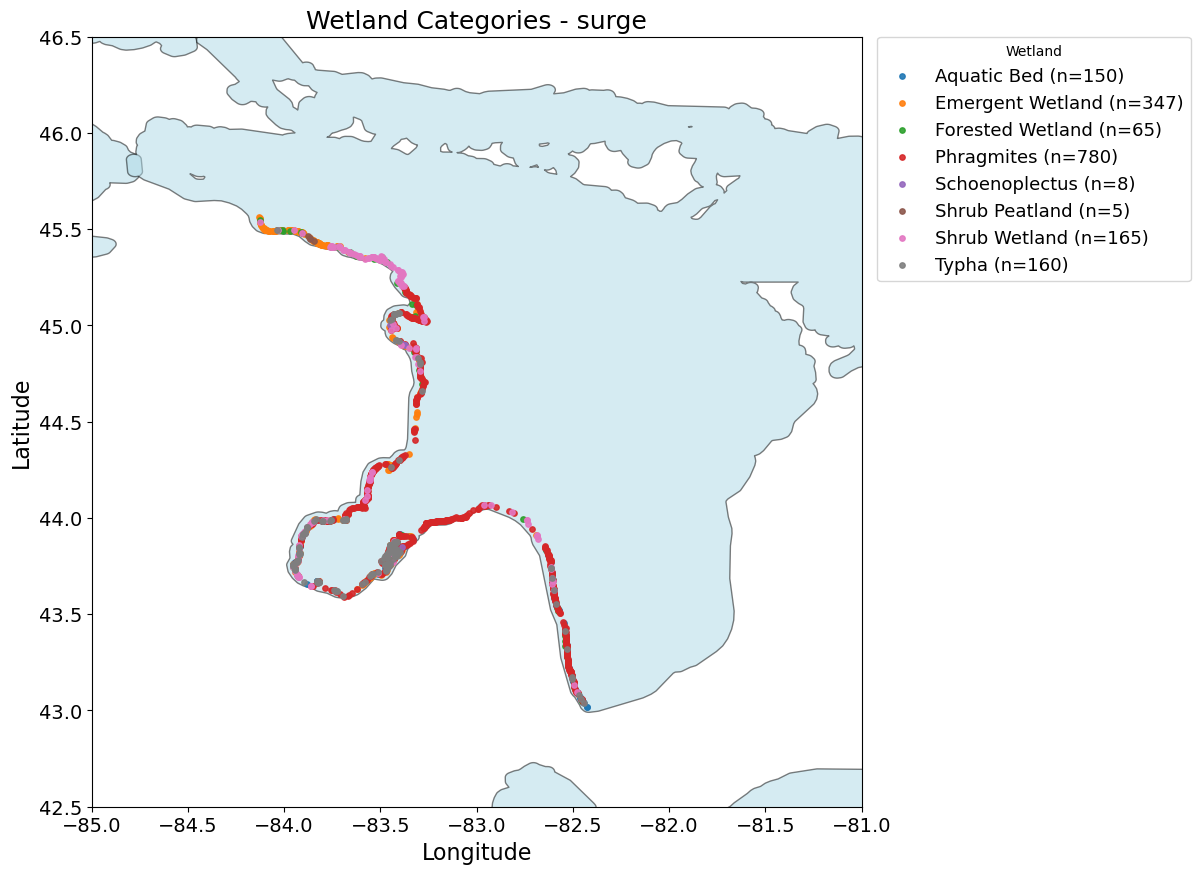

In [167]:
for cat in ['avg', 'high', 'low', 'surge']:
    plot_wetload_distribution(
        cat=cat,
        Lakes=Lakes,
        output_figures="figures",
        title=f"Wetland Categories - {cat}"
    )